In [ ]:
##Author LIU Xiaoquan; Contact Email:aceliu@chuhai.edu.hk

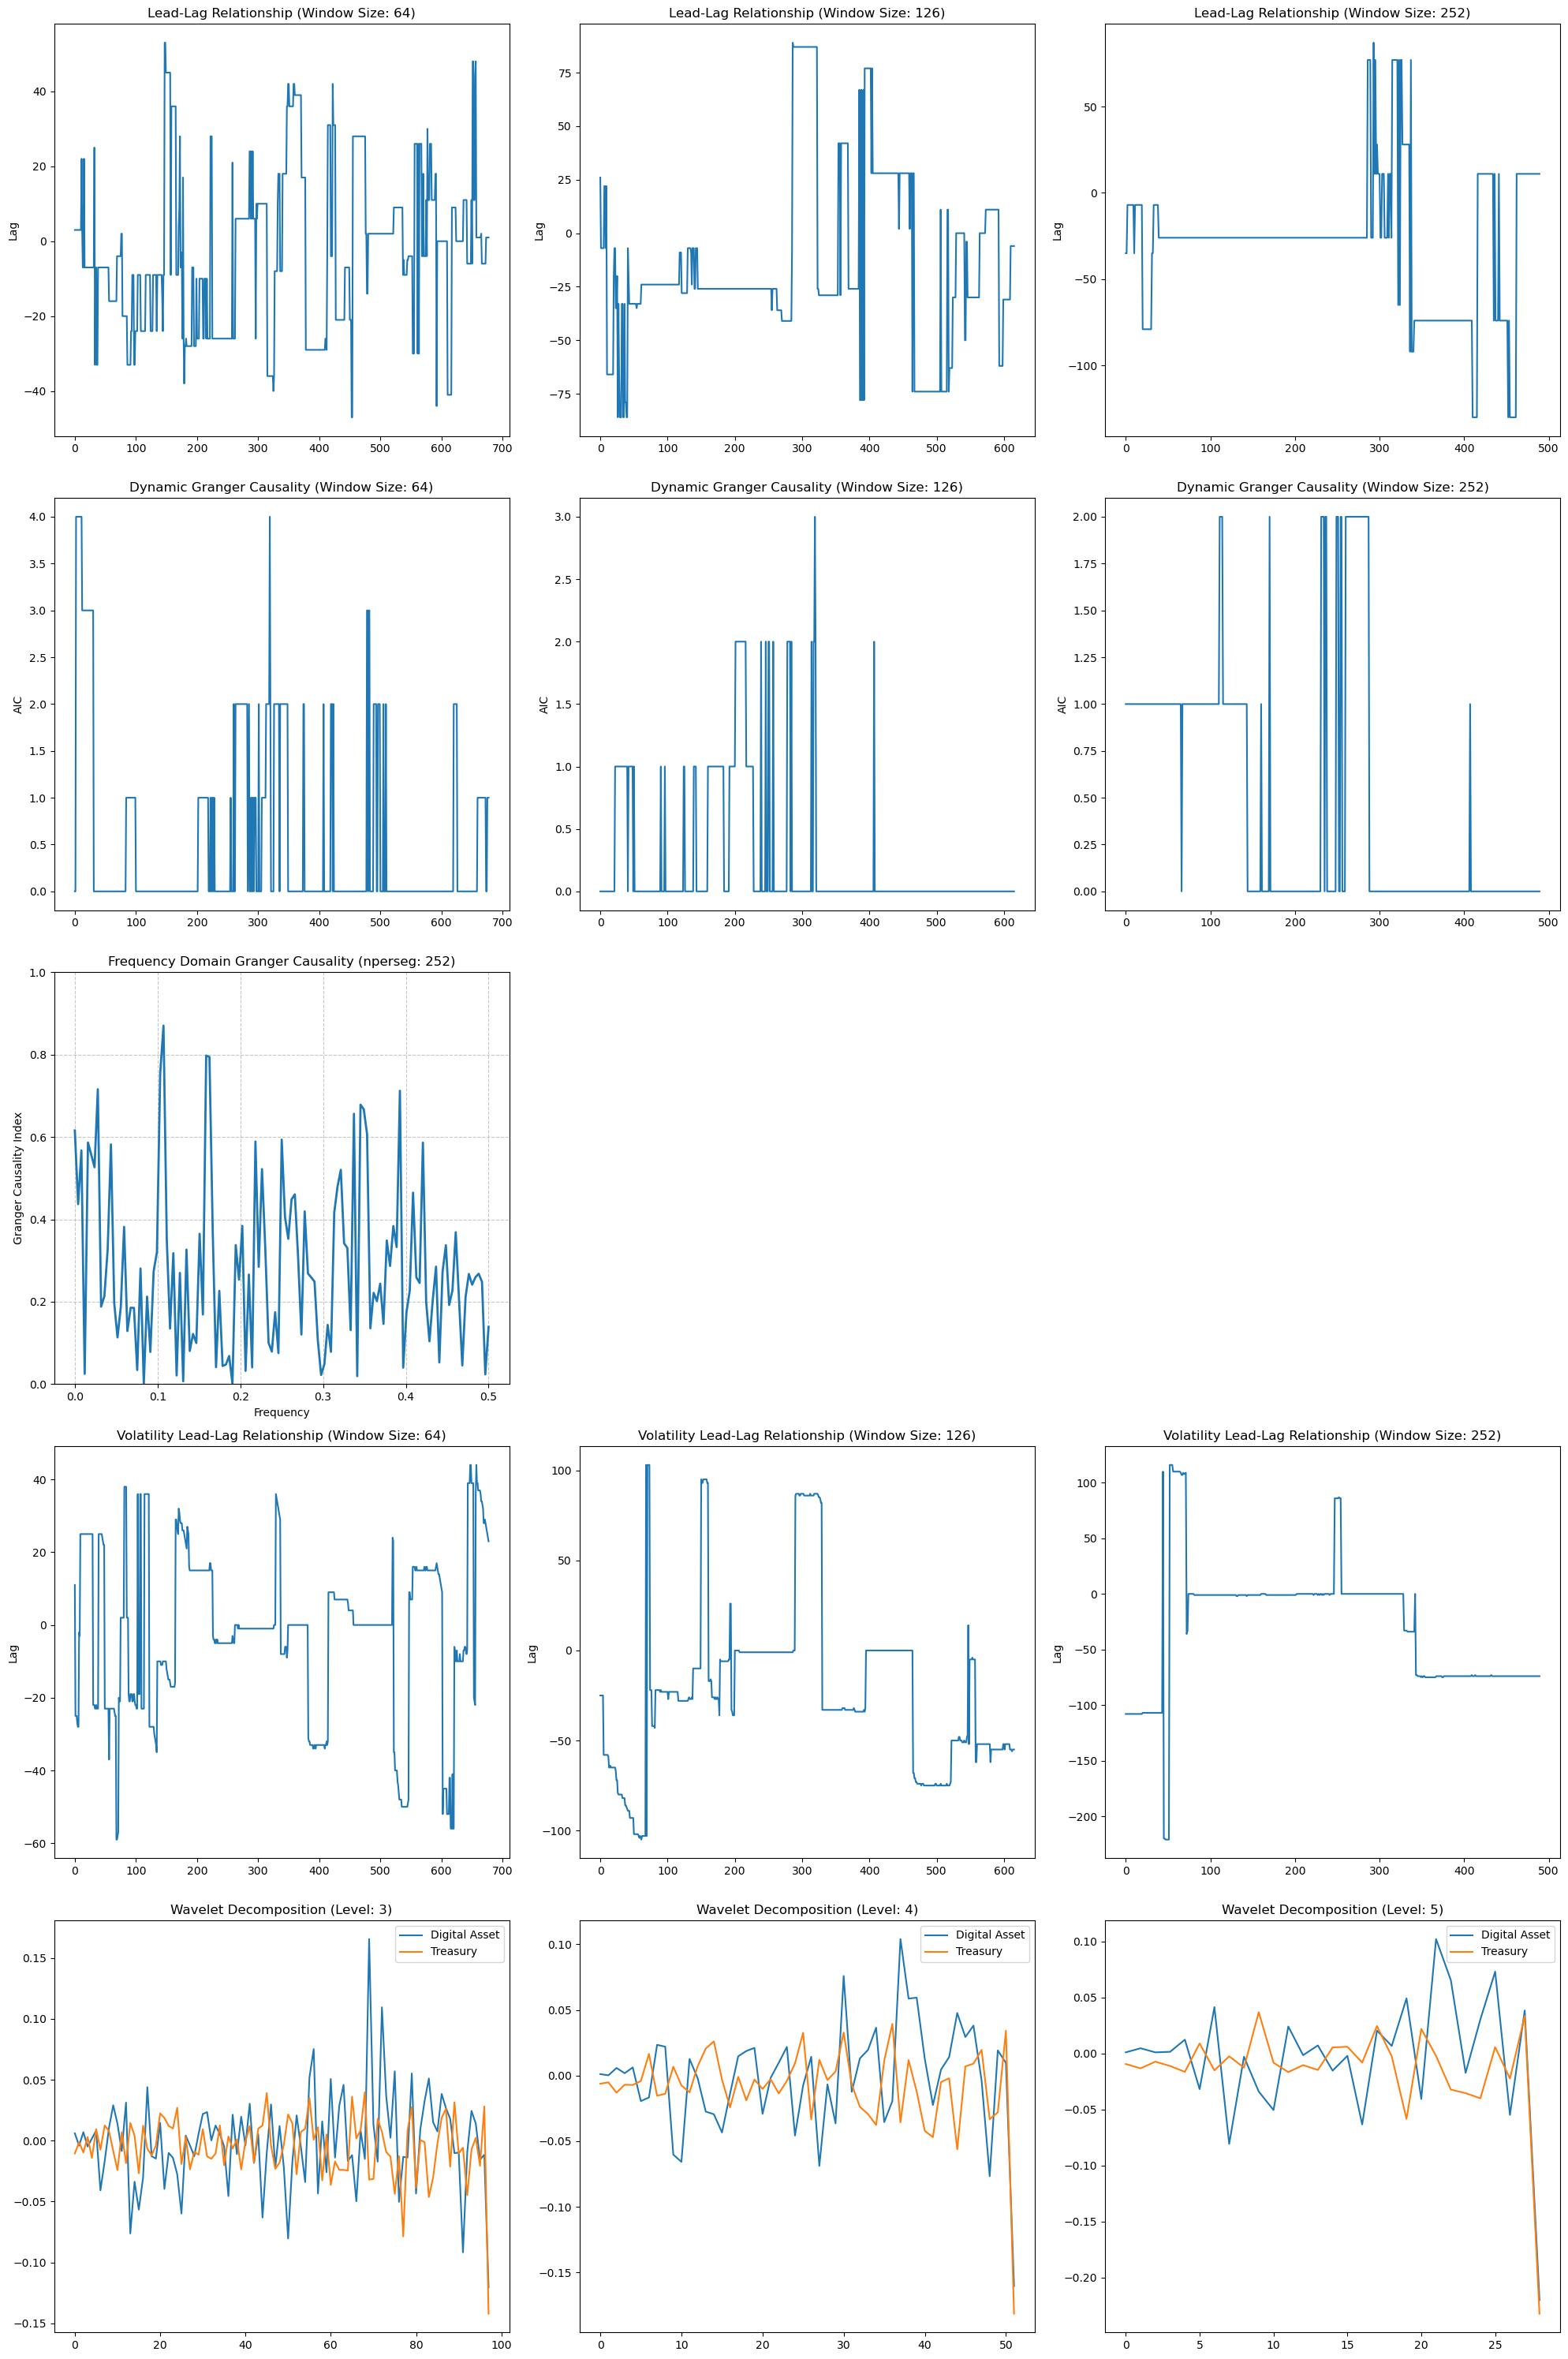

Unit Root Tests:
S&P_digital_asset_index: ADF Statistic: -26.5905, p-value: 0.0000
US_Treasury_10_year: ADF Statistic: -20.6540, p-value: 0.0000
Global_IG_Bond: ADF Statistic: -20.5213, p-value: 0.0000
Global_HY_Bond: ADF Statistic: -6.2642, p-value: 0.0000
Global_Bond_Index: ADF Statistic: -18.9818, p-value: 0.0000

Cointegration Test:
Trace Statistic: 1701.1037
Critical Value (5%): 69.8189


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from scipy import signal
from arch import arch_model
import pywt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings('ignore')

# 1.Data pre-process
def load_and_preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df.pct_change().dropna()

# 2. Fourier MRA
def mra_fourier_lead_lag(x, y, window_sizes=[64,126,252]):
    def cross_correlation(x, y):
        return np.correlate(x - np.mean(x), y - np.mean(y), mode='full')
    
    lead_lags_dict = {}
    for window_size in window_sizes:
        lead_lags = []
        for i in range(len(x) - window_size + 1):
            x_window = x[i:i+window_size]
            y_window = y[i:i+window_size]
            ccf = cross_correlation(x_window, y_window)
            lead_lag = np.argmax(ccf) - (len(ccf) // 2)
            lead_lags.append(lead_lag)
        lead_lags_dict[window_size] = np.array(lead_lags)
    
    return lead_lags_dict

# 3.Dynamic Granger Causality
def dynamic_granger_causality(x, y, max_lag=5, window_sizes=[64,126,252]):
    results_dict = {}
    for window_size in window_sizes:
        results = []
        for i in range(len(x) - window_size + 1):
            x_window = x[i:i+window_size]
            y_window = y[i:i+window_size]
            data_window = pd.concat([x_window, y_window], axis=1)
            model = VAR(data_window)
            results.append(model.select_order(maxlags=max_lag).aic)
        results_dict[window_size] = np.array(results)
    
    return results_dict

# 4. Frenquncy Domian Granger Causality
def spectral_granger_causality(x, y, fs=1.0, npersegs=[252]):
    gc_dict = {}
    for nperseg in npersegs:
        f, Pxx = signal.welch(x, fs=fs, nperseg=nperseg)
        _, Pyy = signal.welch(y, fs=fs, nperseg=nperseg)
        _, Pxy = signal.csd(x, y, fs=fs, nperseg=nperseg)
        
        gc = np.abs(Pxy)**2 / (Pxx * Pyy)
        gc_dict[nperseg] = (f, gc)
    
    return gc_dict

# 5. Multi-scale decompositon
def wavelet_decomposition(x, levels=[3,4,5]):
    coeffs_dict = {}
    for level in levels:
        coeffs_dict[level] = pywt.wavedec(x, 'db4', level=level)
    return coeffs_dict

# 6. GARCH Volatility
def garch_volatility(returns):
    model = arch_model(returns, vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')
    return results.conditional_volatility

# 7.Empirical annalysis with data
def empirical_analysis(data):
    digital_asset = data['S&P_digital_asset_index']
    treasury = data['US_Treasury_10_year']
    
    lead_lags = mra_fourier_lead_lag(digital_asset, treasury)
    
    granger_results = dynamic_granger_causality(digital_asset, treasury)
    
    gc_results = spectral_granger_causality(digital_asset, treasury)
    
    digital_vol = garch_volatility(digital_asset)
    treasury_vol = garch_volatility(treasury)
    vol_lead_lags = mra_fourier_lead_lag(digital_vol, treasury_vol)
    
    digital_wavelets = wavelet_decomposition(digital_asset)
    treasury_wavelets = wavelet_decomposition(treasury)
    
    # Results Visualization
    plt.figure(figsize=(20, 30))
    
   
    for i, (window_size, lead_lag) in enumerate(lead_lags.items()):
        plt.subplot(5, 3, i+1)
        plt.plot(lead_lag)
        plt.title(f'Lead-Lag Relationship (Window Size: {window_size})')
        plt.ylabel('Lag')
    
    for i, (window_size, granger_result) in enumerate(granger_results.items()):
        plt.subplot(5, 3, i+4)
        plt.plot(granger_result)
        plt.title(f'Dynamic Granger Causality (Window Size: {window_size})')
        plt.ylabel('AIC')
    

    for i, (nperseg, (f, gc)) in enumerate(gc_results.items()):
        plt.subplot(5, 3, i+7)
        plt.plot(f, gc, linewidth=2)
        plt.title(f'Frequency Domain Granger Causality (nperseg: {nperseg})')
        plt.xlabel('Frequency')
        plt.ylabel('Granger Causality Index')
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
    

    for i, (window_size, vol_lead_lag) in enumerate(vol_lead_lags.items()):
        plt.subplot(5, 3, i+10)
        plt.plot(vol_lead_lag)
        plt.title(f'Volatility Lead-Lag Relationship (Window Size: {window_size})')
        plt.ylabel('Lag')
    

    for i, (level, coeffs) in enumerate(digital_wavelets.items()):
        plt.subplot(5, 3, i+13)
        plt.plot(coeffs[0], label='Digital Asset')
        plt.plot(treasury_wavelets[level][0], label='Treasury')
        plt.title(f'Wavelet Decomposition (Level: {level})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 8. Robustness checks
def robustness_checks(data):
    # 8.1 unit roots
    def adf_test(series):
        result = adfuller(series)
        return f'ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}'
    
    print("Unit Root Tests:")
    for column in data.columns:
        print(f"{column}: {adf_test(data[column])}")
    
    # 8.2 Cointegration
    print("\nCointegration Test:")
    johansen_result = coint_johansen(data, det_order=0, k_ar_diff=1)
    print(f"Trace Statistic: {johansen_result.lr1[0]:.4f}")
    print(f"Critical Value (5%): {johansen_result.cvt[0,1]:.4f}")

# main
if __name__ == "__main__":
    data = load_and_preprocess_data('/Users/xiaoquanliu/Desktop/data.xlsx')
    empirical_analysis(data)
    robustness_checks(data)

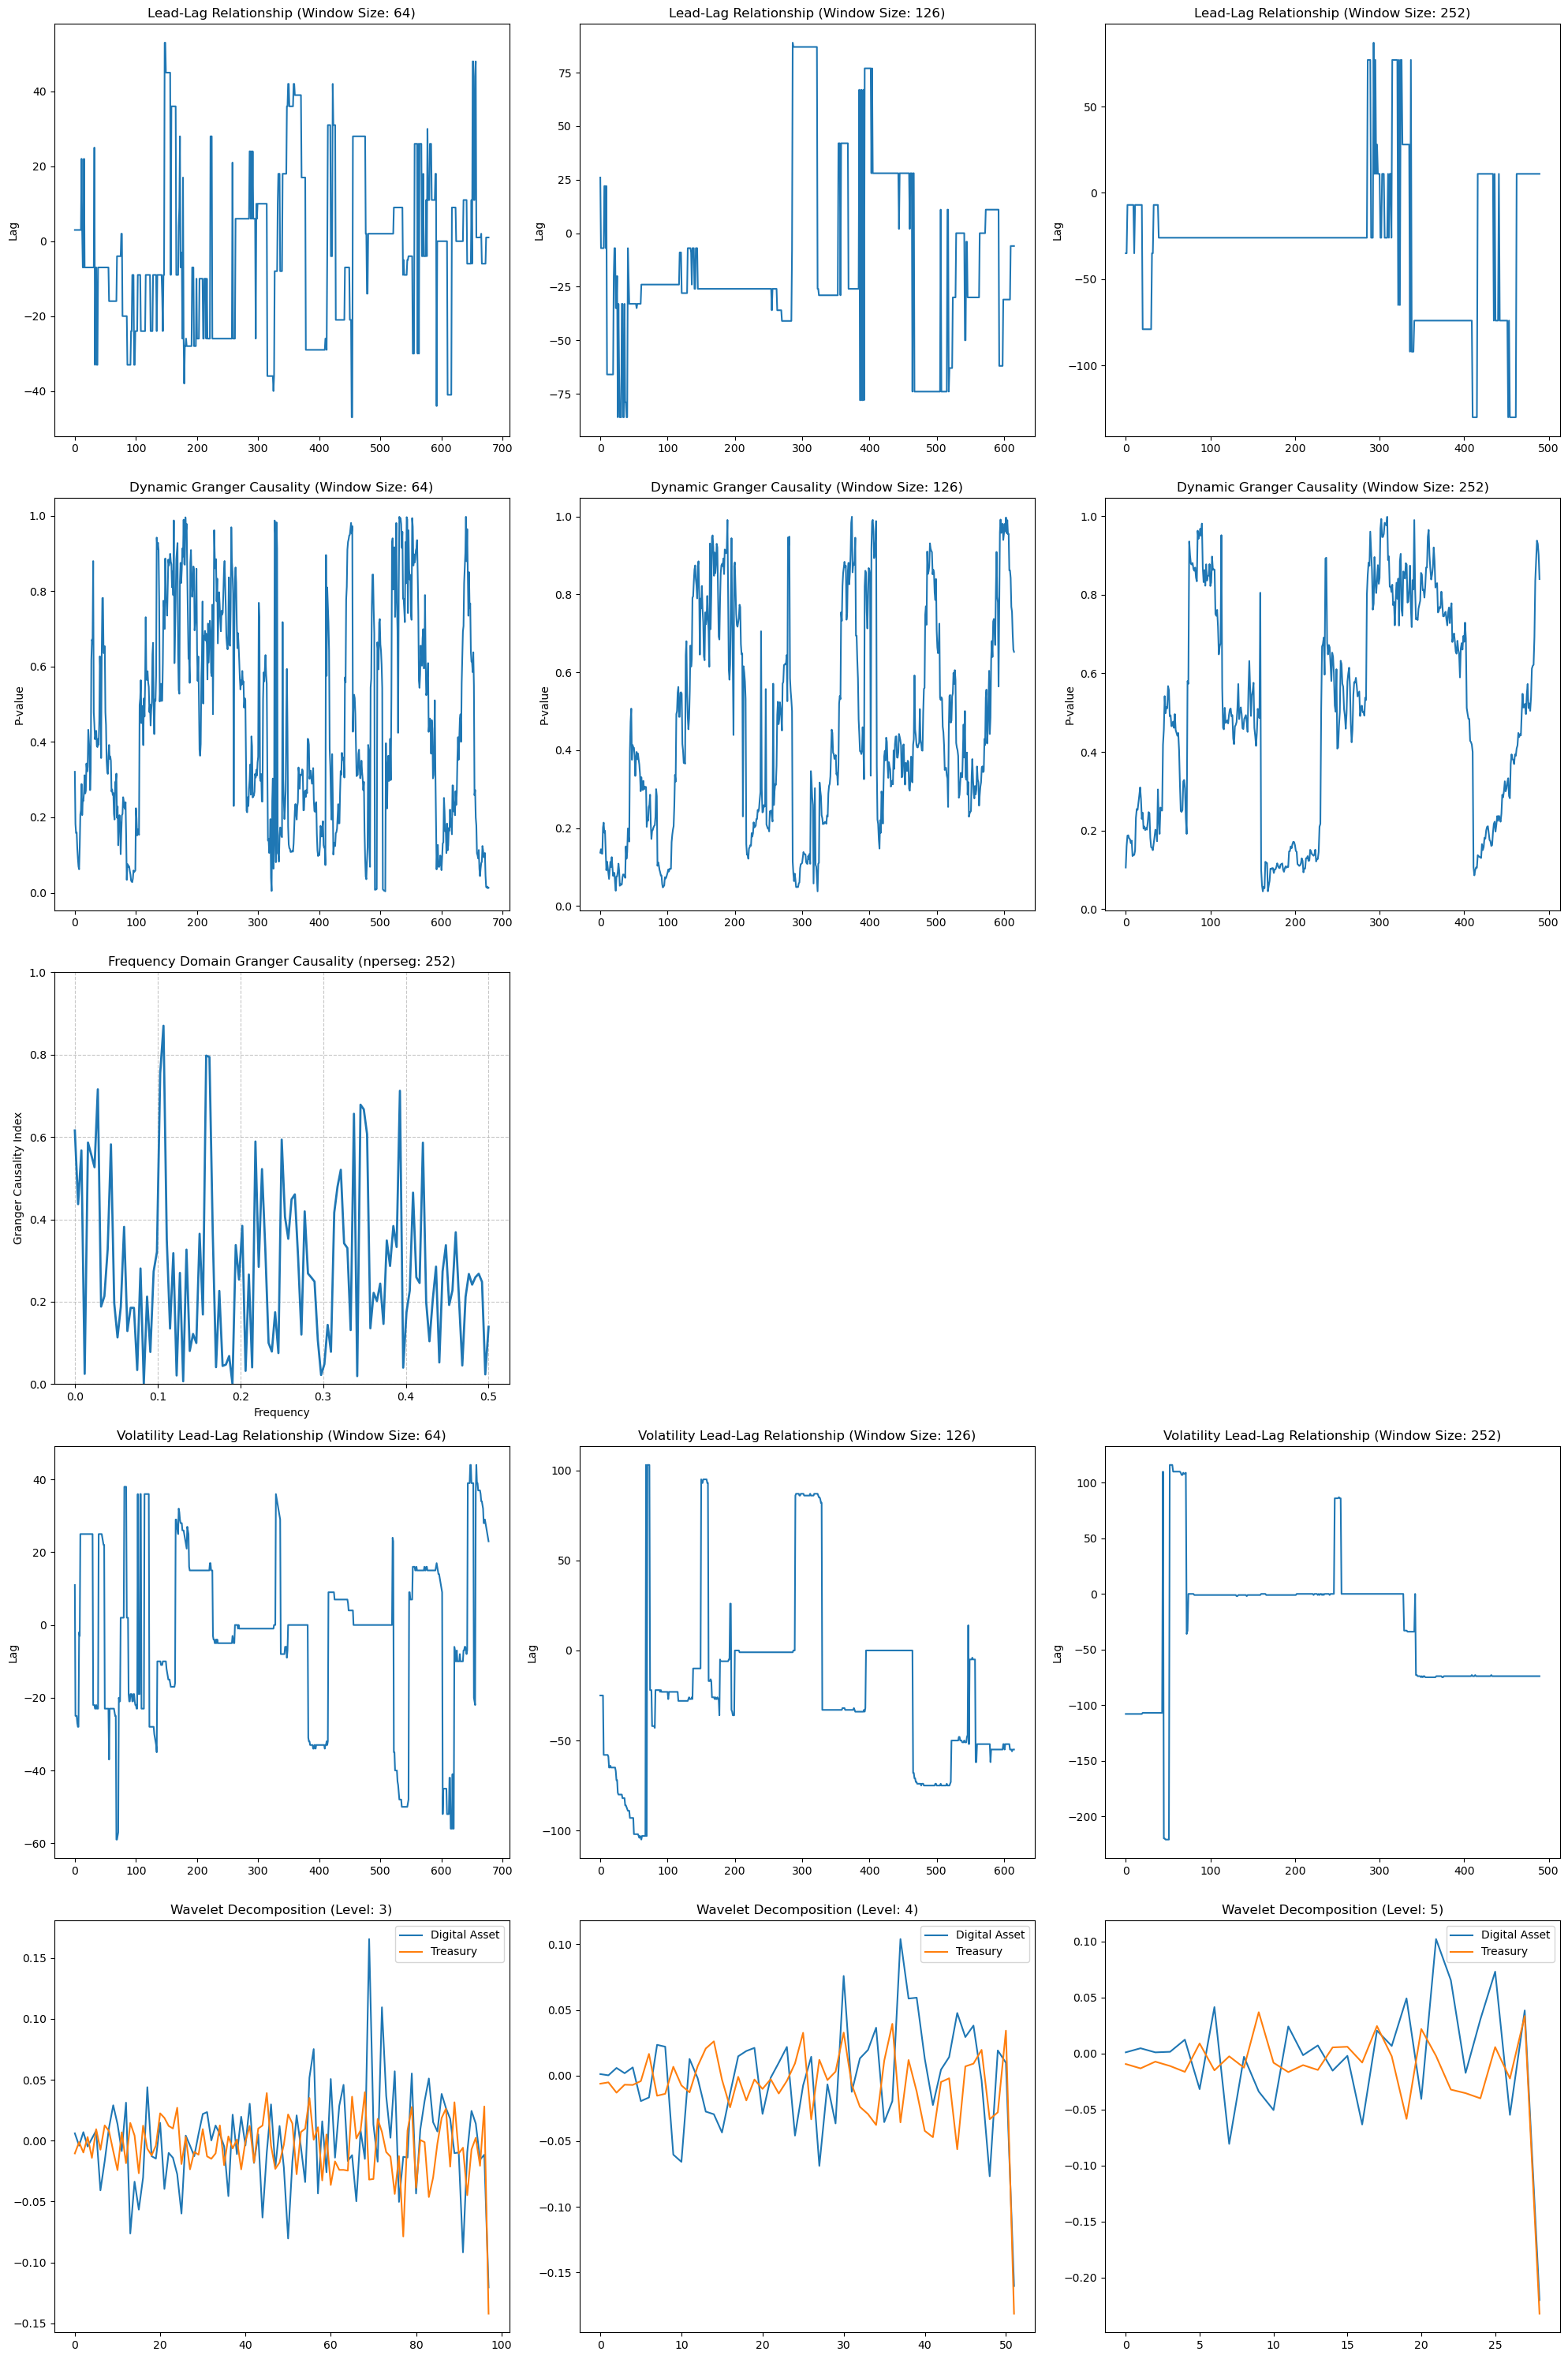

Unit Root Tests:
S&P_digital_asset_index: ADF Statistic: -26.5905, p-value: 0.0000
US_Treasury_10_year: ADF Statistic: -20.6540, p-value: 0.0000
Global_IG_Bond: ADF Statistic: -20.5213, p-value: 0.0000
Global_HY_Bond: ADF Statistic: -6.2642, p-value: 0.0000
Global_Bond_Index: ADF Statistic: -18.9818, p-value: 0.0000

Cointegration Test:
Trace Statistic: 1701.1037
Critical Value (5%): 69.8189
Results saved to '/Users/xiaoquanliu/Desktop/results2.xlsx'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from scipy import signal
from arch import arch_model
import pywt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
import os
warnings.filterwarnings('ignore')

# Keep the def
def load_and_preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df.pct_change().dropna()

def mra_fourier_lead_lag(x, y, window_sizes=[64,126,252]):
    def cross_correlation(x, y):
        return np.correlate(x - np.mean(x), y - np.mean(y), mode='full')
    
    lead_lags_dict = {}
    for window_size in window_sizes:
        lead_lags = []
        for i in range(len(x) - window_size + 1):
            x_window = x[i:i+window_size]
            y_window = y[i:i+window_size]
            ccf = cross_correlation(x_window, y_window)
            lead_lag = np.argmax(ccf) - (len(ccf) // 2)
            lead_lags.append(lead_lag)
        lead_lags_dict[window_size] = np.array(lead_lags)
    
    return lead_lags_dict

def dynamic_granger_causality(x, y, max_lag=10, window_sizes=[64,126,252]):
    results_dict = {}
    for window_size in window_sizes:
        p_values = []
        for i in range(len(x) - window_size + 1):
            x_window = x[i:i+window_size]
            y_window = y[i:i+window_size]
            data_window = pd.concat([x_window, y_window], axis=1)
            data_window.columns = ['x', 'y']
            
            # optimal_lag AIC
            model = VAR(data_window)
            results = model.fit(maxlags=max_lag, ic='aic')
            optimal_lag = results.k_ar
            
            #  optimal_lag at least 1
            optimal_lag = max(1, optimal_lag)
            
            granger_result = grangercausalitytests(data_window, maxlag=optimal_lag, verbose=False)
            p_value = granger_result[optimal_lag][0]['ssr_ftest'][1]
            p_values.append(p_value)
        results_dict[window_size] = np.array(p_values)
    
    return results_dict

def spectral_granger_causality(x, y, fs=1.0, npersegs=[252]):
    gc_dict = {}
    for nperseg in npersegs:
        f, Pxx = signal.welch(x, fs=fs, nperseg=nperseg)
        _, Pyy = signal.welch(y, fs=fs, nperseg=nperseg)
        _, Pxy = signal.csd(x, y, fs=fs, nperseg=nperseg)
        
        gc = np.abs(Pxy)**2 / (Pxx * Pyy)
        gc_dict[nperseg] = (f, gc)
    
    return gc_dict


def wavelet_decomposition(x, levels=[3,4,5]):
    coeffs_dict = {}
    for level in levels:
        coeffs_dict[level] = pywt.wavedec(x, 'db4', level=level)
    return coeffs_dict

def garch_volatility(returns):
    model = arch_model(returns, vol='GARCH', p=1, q=1)
    results = model.fit(disp='off')
    return results.conditional_volatility


def empirical_analysis(data):
    digital_asset = data['S&P_digital_asset_index']
    treasury = data['US_Treasury_10_year']
    
   
    lead_lags = mra_fourier_lead_lag(digital_asset, treasury)
    
  
    granger_results = dynamic_granger_causality(digital_asset, treasury)
    

    gc_results = spectral_granger_causality(digital_asset, treasury)
    
   
    digital_vol = garch_volatility(digital_asset)
    treasury_vol = garch_volatility(treasury)
    vol_lead_lags = mra_fourier_lead_lag(digital_vol, treasury_vol)
    
    
    digital_wavelets = wavelet_decomposition(digital_asset)
    treasury_wavelets = wavelet_decomposition(treasury)
    
    # Visualization
    plt.figure(figsize=(20, 30))
    

    for i, (window_size, lead_lag) in enumerate(lead_lags.items()):
        plt.subplot(5, 3, i+1)
        plt.plot(lead_lag)
        plt.title(f'Lead-Lag Relationship (Window Size: {window_size})')
        plt.ylabel('Lag')
    
   
    for i, (window_size, granger_result) in enumerate(granger_results.items()):
        plt.subplot(5, 3, i+4)
        plt.plot(granger_result)
        plt.title(f'Dynamic Granger Causality (Window Size: {window_size})')
        plt.ylabel('P-value')
    
   
    for i, (nperseg, (f, gc)) in enumerate(gc_results.items()):
        plt.subplot(5, 3, i+7)
        plt.plot(f, gc, linewidth=2)
        plt.title(f'Frequency Domain Granger Causality (nperseg: {nperseg})')
        plt.xlabel('Frequency')
        plt.ylabel('Granger Causality Index')
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
    
 
    for i, (window_size, vol_lead_lag) in enumerate(vol_lead_lags.items()):
        plt.subplot(5, 3, i+10)
        plt.plot(vol_lead_lag)
        plt.title(f'Volatility Lead-Lag Relationship (Window Size: {window_size})')
        plt.ylabel('Lag')
    
 
    for i, (level, coeffs) in enumerate(digital_wavelets.items()):
        plt.subplot(5, 3, i+13)
        plt.plot(coeffs[0], label='Digital Asset')
        plt.plot(treasury_wavelets[level][0], label='Treasury')
        plt.title(f'Wavelet Decomposition (Level: {level})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()



# 8. Save to Excel
def save_results_to_excel(data):
    # set the save path
    save_path = os.path.expanduser('~/Desktop')
    file_name = 'results2.xlsx'
    full_path = os.path.join(save_path, file_name)
    
    digital_asset = data['S&P_digital_asset_index']
    treasury = data['US_Treasury_10_year']
    
    # 252 Lead-Lag Relationship
    lead_lags = mra_fourier_lead_lag(digital_asset, treasury, window_sizes=[252])
    lead_lag_252 = lead_lags[252]
    
    # 252 Dynamic Granger Causality
    granger_results = dynamic_granger_causality(digital_asset, treasury, window_sizes=[252])
    granger_252 = granger_results[252]
    
    # time index
    time_index = data.index[251:]  
    
    # Lead-Lag dataframe
    lead_lag_df = pd.DataFrame({
        'Date': time_index,
        'Lead-Lag': lead_lag_252,
        'Relationship': ['Digital Asset leads Treasury' if lag > 0 else 'Treasury leads Digital Asset' if lag < 0 else 'No lead-lag' for lag in lead_lag_252]
    })
    
    # Dynamic Granger dataframe
    granger_df = pd.DataFrame({
        'Date': time_index,
        'P-value': granger_252,
        'Significance': ['Significant at 1%' if p < 0.01 else 'Significant at 5%' if p < 0.05 else 'Significant at 10%' if p < 0.1 else 'Not significant' for p in granger_252]
    })
    
    # save to excel
    with pd.ExcelWriter(full_path) as writer:
        lead_lag_df.to_excel(writer, sheet_name='Lead-Lag', index=False)
        granger_df.to_excel(writer, sheet_name='Dynamic Granger', index=False)
    
    print(f"Results saved to '{full_path}'")

# main
if __name__ == "__main__":
    data = load_and_preprocess_data('/Users/xiaoquanliu/Desktop/data.xlsx')
    empirical_analysis(data)
    robustness_checks(data)
    save_results_to_excel(data)



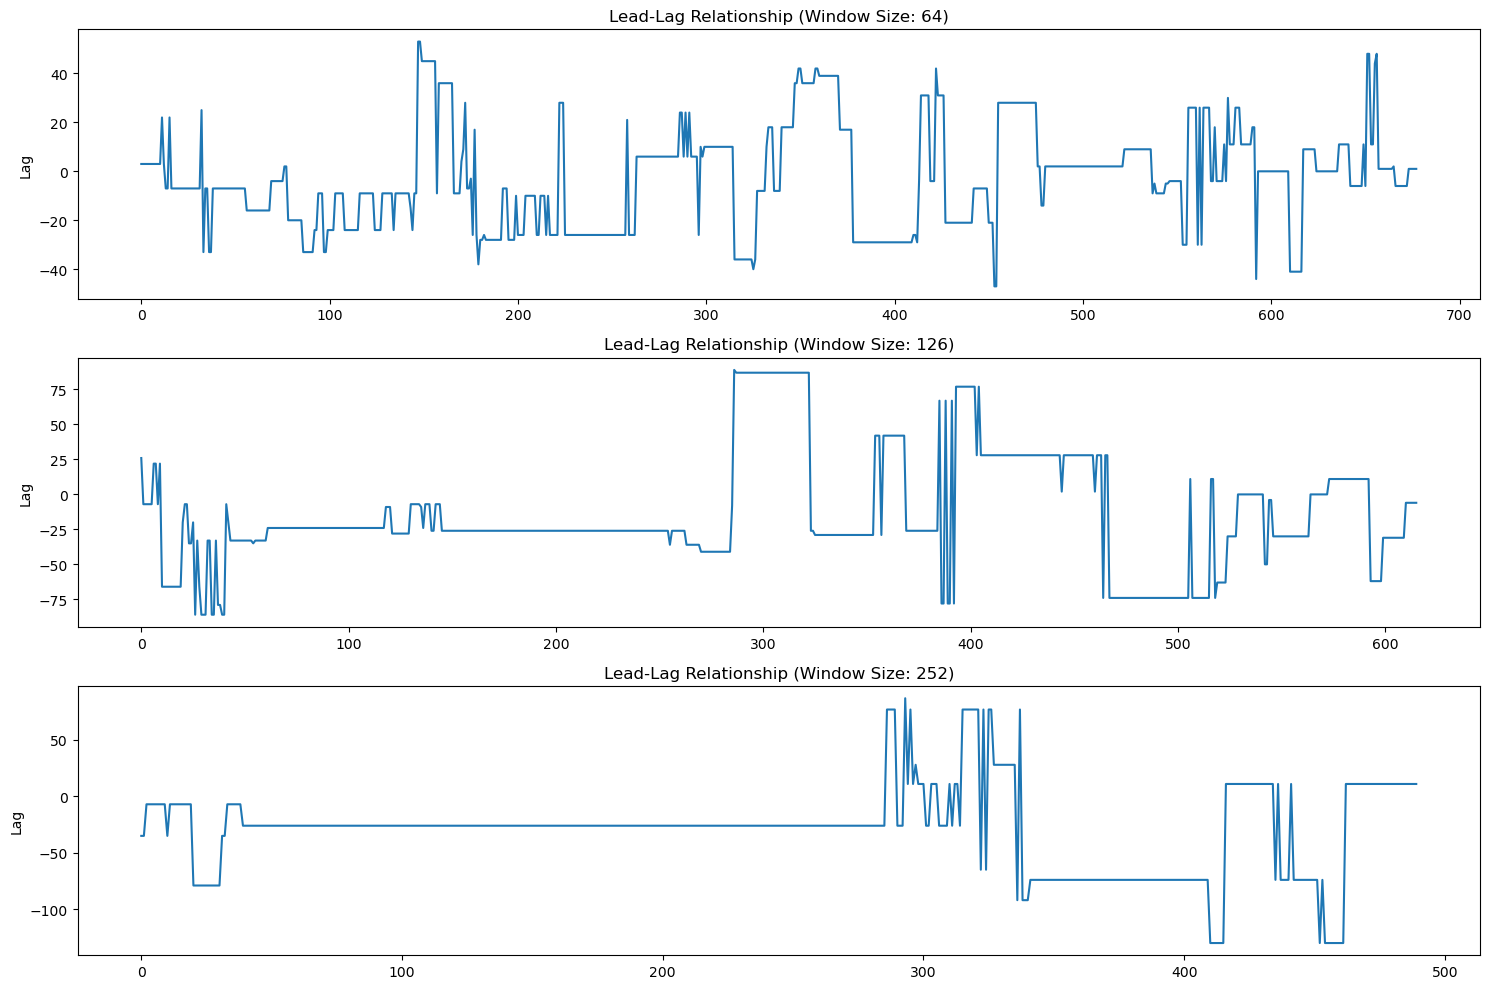

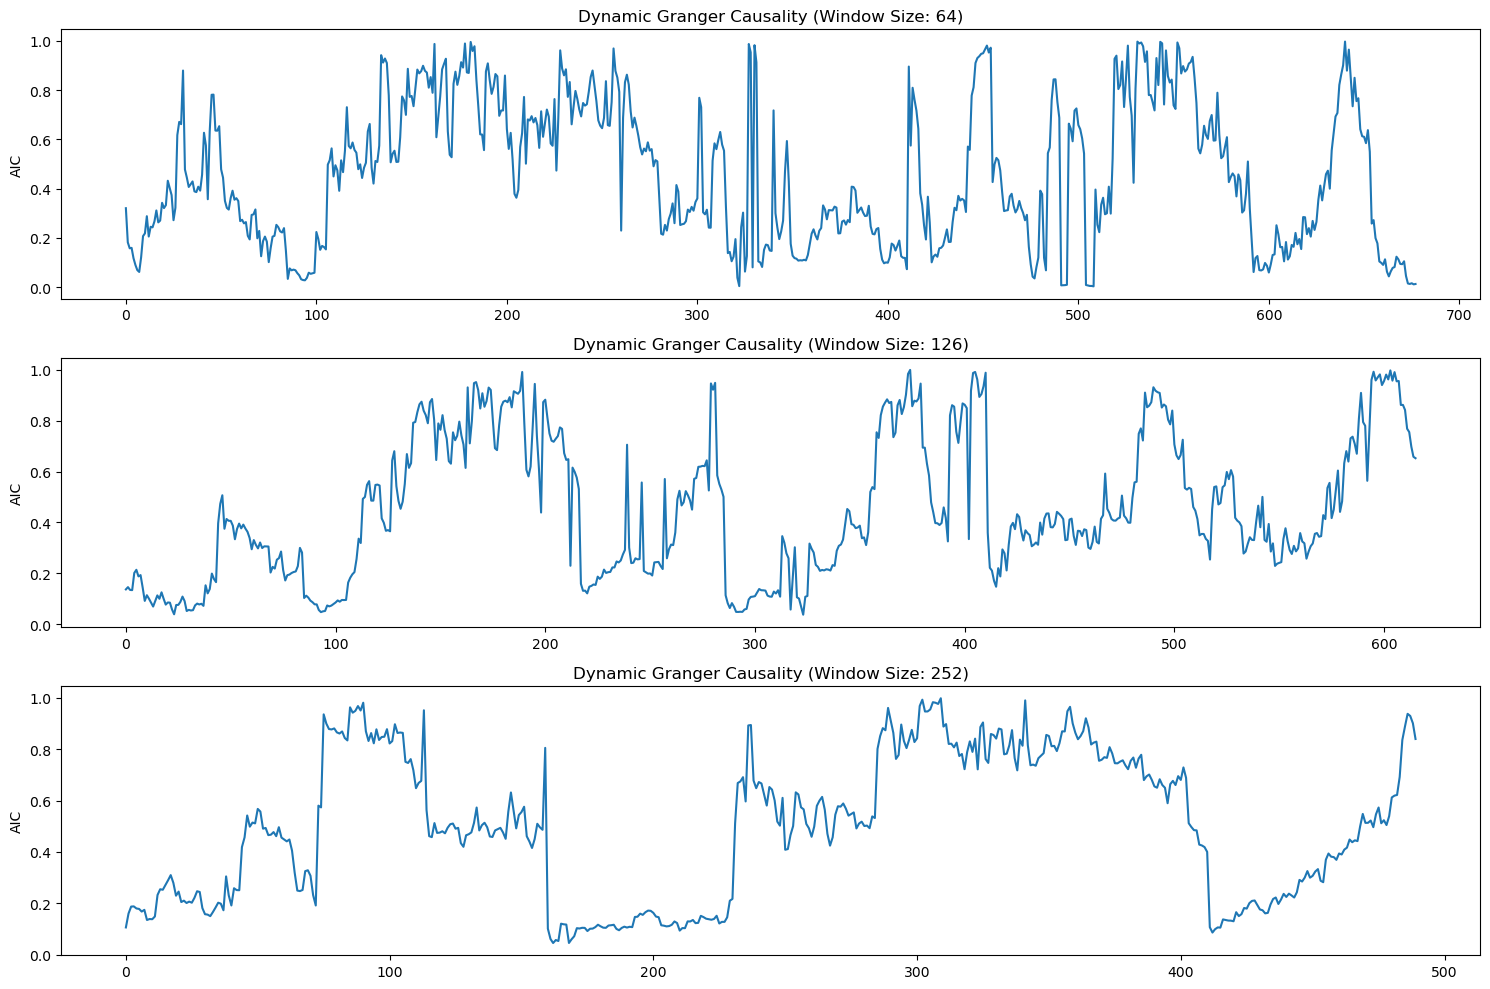

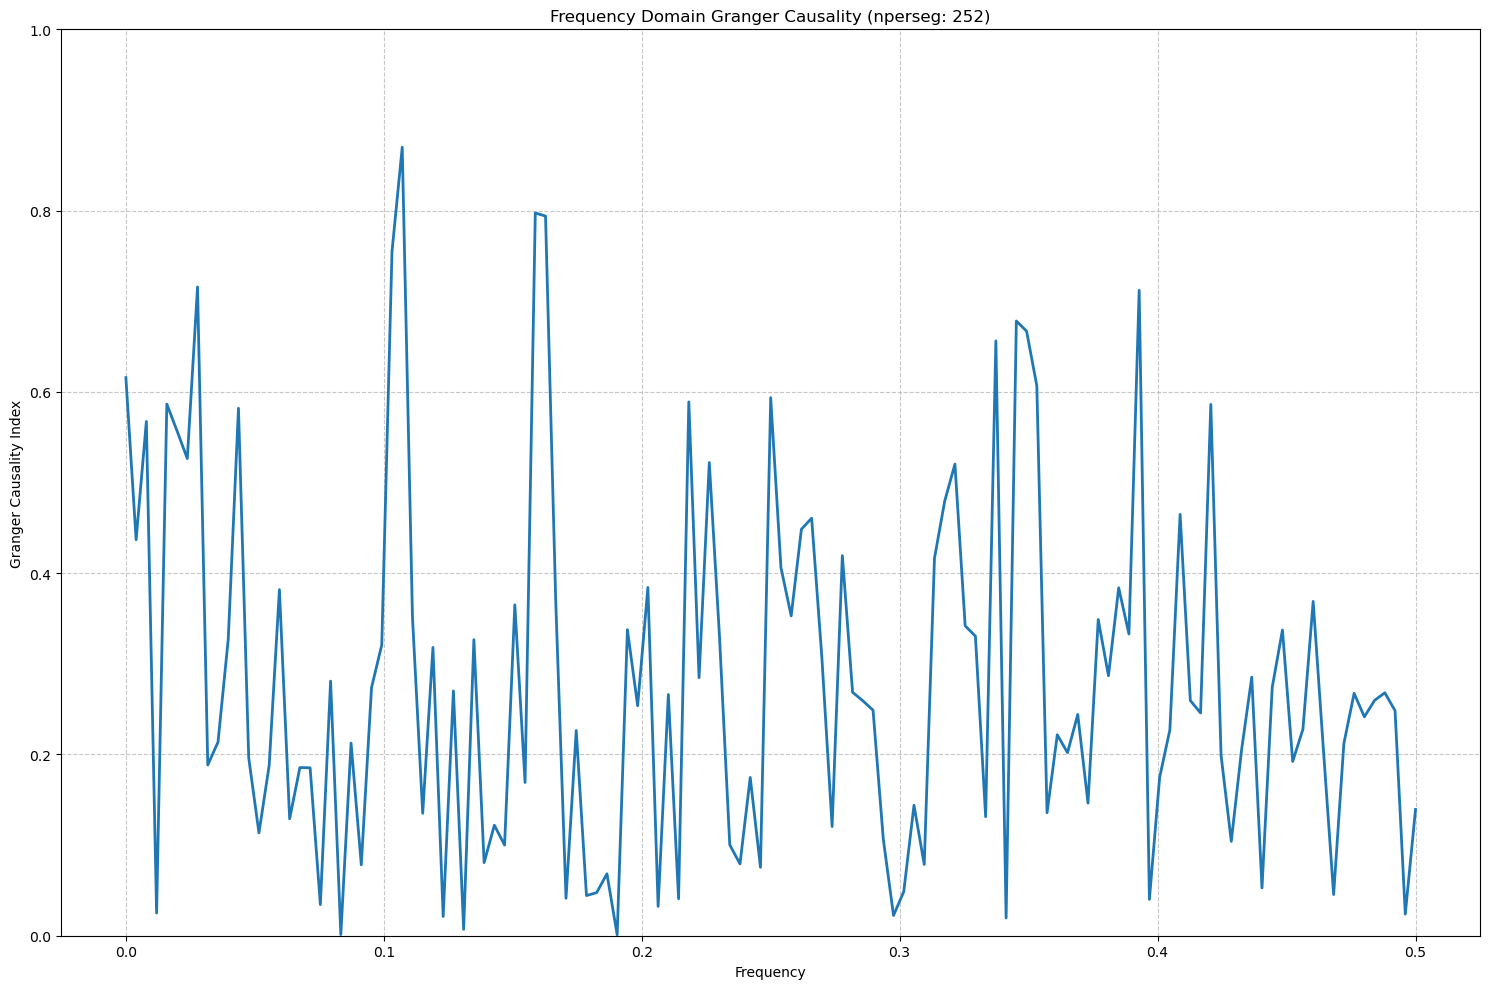

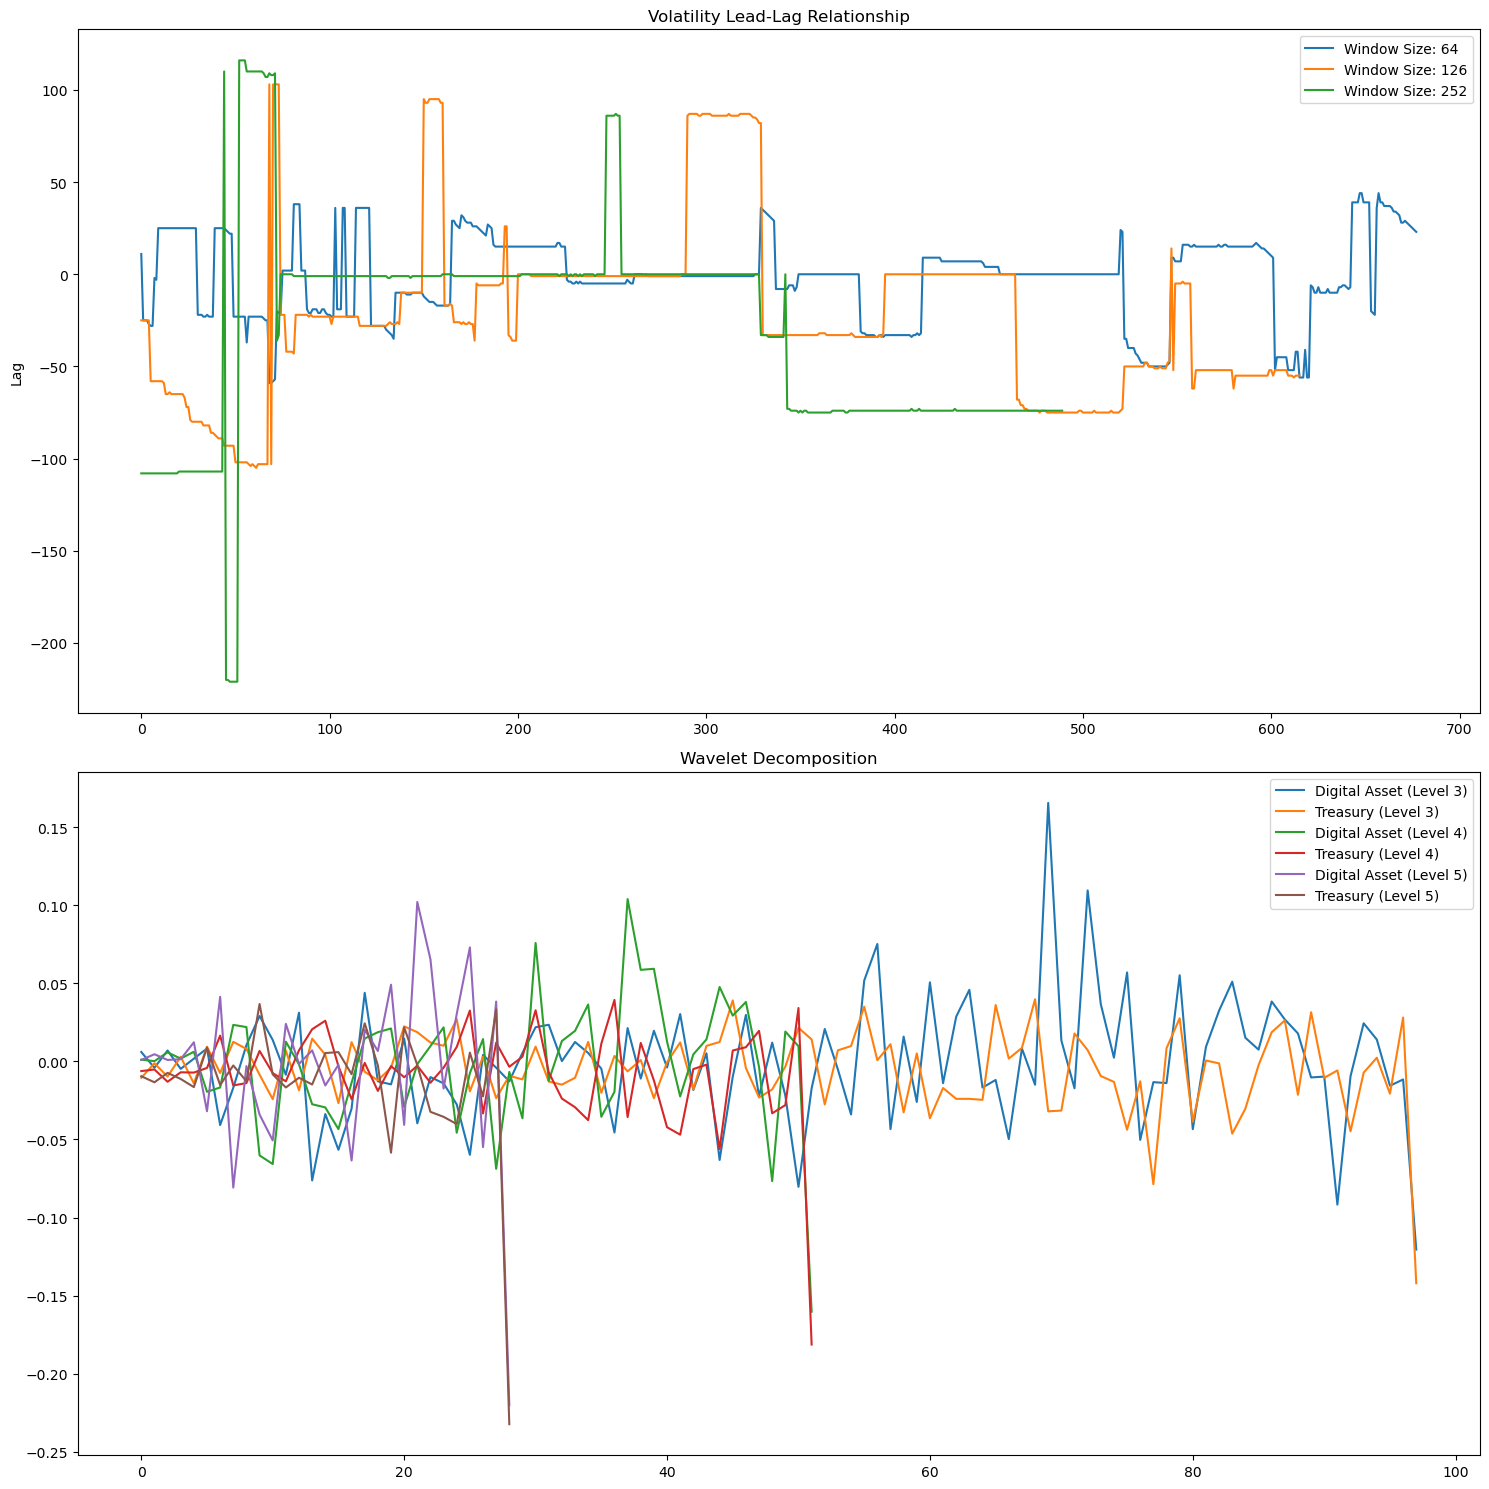

Unit Root Tests:
S&P_digital_asset_index: ADF Statistic: -26.5905, p-value: 0.0000
US_Treasury_10_year: ADF Statistic: -20.6540, p-value: 0.0000
Global_IG_Bond: ADF Statistic: -20.5213, p-value: 0.0000
Global_HY_Bond: ADF Statistic: -6.2642, p-value: 0.0000
Global_Bond_Index: ADF Statistic: -18.9818, p-value: 0.0000

Cointegration Test:
Trace Statistic: 1701.1037
Critical Value (5%): 69.8189


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from scipy import signal
from arch import arch_model
import pywt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings('ignore')

# Keep previous Def...

def empirical_analysis(data):
    digital_asset = data['S&P_digital_asset_index']
    treasury = data['US_Treasury_10_year']
    
 
    lead_lags = mra_fourier_lead_lag(digital_asset, treasury)

    granger_results = dynamic_granger_causality(digital_asset, treasury)

    gc_results = spectral_granger_causality(digital_asset, treasury)
    

    digital_vol = garch_volatility(digital_asset)
    treasury_vol = garch_volatility(treasury)
    vol_lead_lags = mra_fourier_lead_lag(digital_vol, treasury_vol)
    
    digital_wavelets = wavelet_decomposition(digital_asset)
    treasury_wavelets = wavelet_decomposition(treasury)
    

 
    plt.figure(figsize=(15, 10))
    for i, (window_size, lead_lag) in enumerate(lead_lags.items()):
        plt.subplot(len(lead_lags), 1, i+1)
        plt.plot(lead_lag)
        plt.title(f'Lead-Lag Relationship (Window Size: {window_size})')
        plt.ylabel('Lag')
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(15, 10))
    for i, (window_size, granger_result) in enumerate(granger_results.items()):
        plt.subplot(len(granger_results), 1, i+1)
        plt.plot(granger_result)
        plt.title(f'Dynamic Granger Causality (Window Size: {window_size})')
        plt.ylabel('AIC')
    plt.tight_layout()
    plt.show()
    

    plt.figure(figsize=(15, 10))
    for i, (nperseg, (f, gc)) in enumerate(gc_results.items()):
        plt.subplot(len(gc_results), 1, i+1)
        plt.plot(f, gc, linewidth=2)
        plt.title(f'Frequency Domain Granger Causality (nperseg: {nperseg})')
        plt.xlabel('Frequency')
        plt.ylabel('Granger Causality Index')
        plt.ylim(0, 1)
        plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
 
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    

    for i, (window_size, vol_lead_lag) in enumerate(vol_lead_lags.items()):
        axs[0].plot(vol_lead_lag, label=f'Window Size: {window_size}')
    axs[0].set_title('Volatility Lead-Lag Relationship')
    axs[0].set_ylabel('Lag')
    axs[0].legend()
    

    for i, (level, coeffs) in enumerate(digital_wavelets.items()):
        axs[1].plot(coeffs[0], label=f'Digital Asset (Level {level})')
        axs[1].plot(treasury_wavelets[level][0], label=f'Treasury (Level {level})')
    axs[1].set_title('Wavelet Decomposition')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

# main
if __name__ == "__main__":
    data = load_and_preprocess_data('/Users/xiaoquanliu/Desktop/data.xlsx')
    empirical_analysis(data)
    robustness_checks(data)

Data shape: (741, 5)
Data columns: Index(['S&P_digital_asset_index', 'US_Treasury_10_year', 'Global_IG_Bond',
       'Global_HY_Bond', 'Global_Bond_Index'],
      dtype='object')
Data head:
             S&P_digital_asset_index  US_Treasury_10_year  Global_IG_Bond  \
Date                                                                       
2024-06-07                -0.000060            -0.007499        0.001702   
2024-06-06                 0.020376            -0.033044        0.008835   
2024-06-05                 0.015929            -0.002683        0.001123   
2024-06-04                -0.013604             0.011788       -0.003402   
2024-06-03                -0.017356             0.014448        0.000000   

            Global_HY_Bond  Global_Bond_Index  
Date                                           
2024-06-07       -0.000160           0.004513  
2024-06-06        0.002214           0.007382  
2024-06-05        0.001505          -0.000442  
2024-06-04       -0.002878          

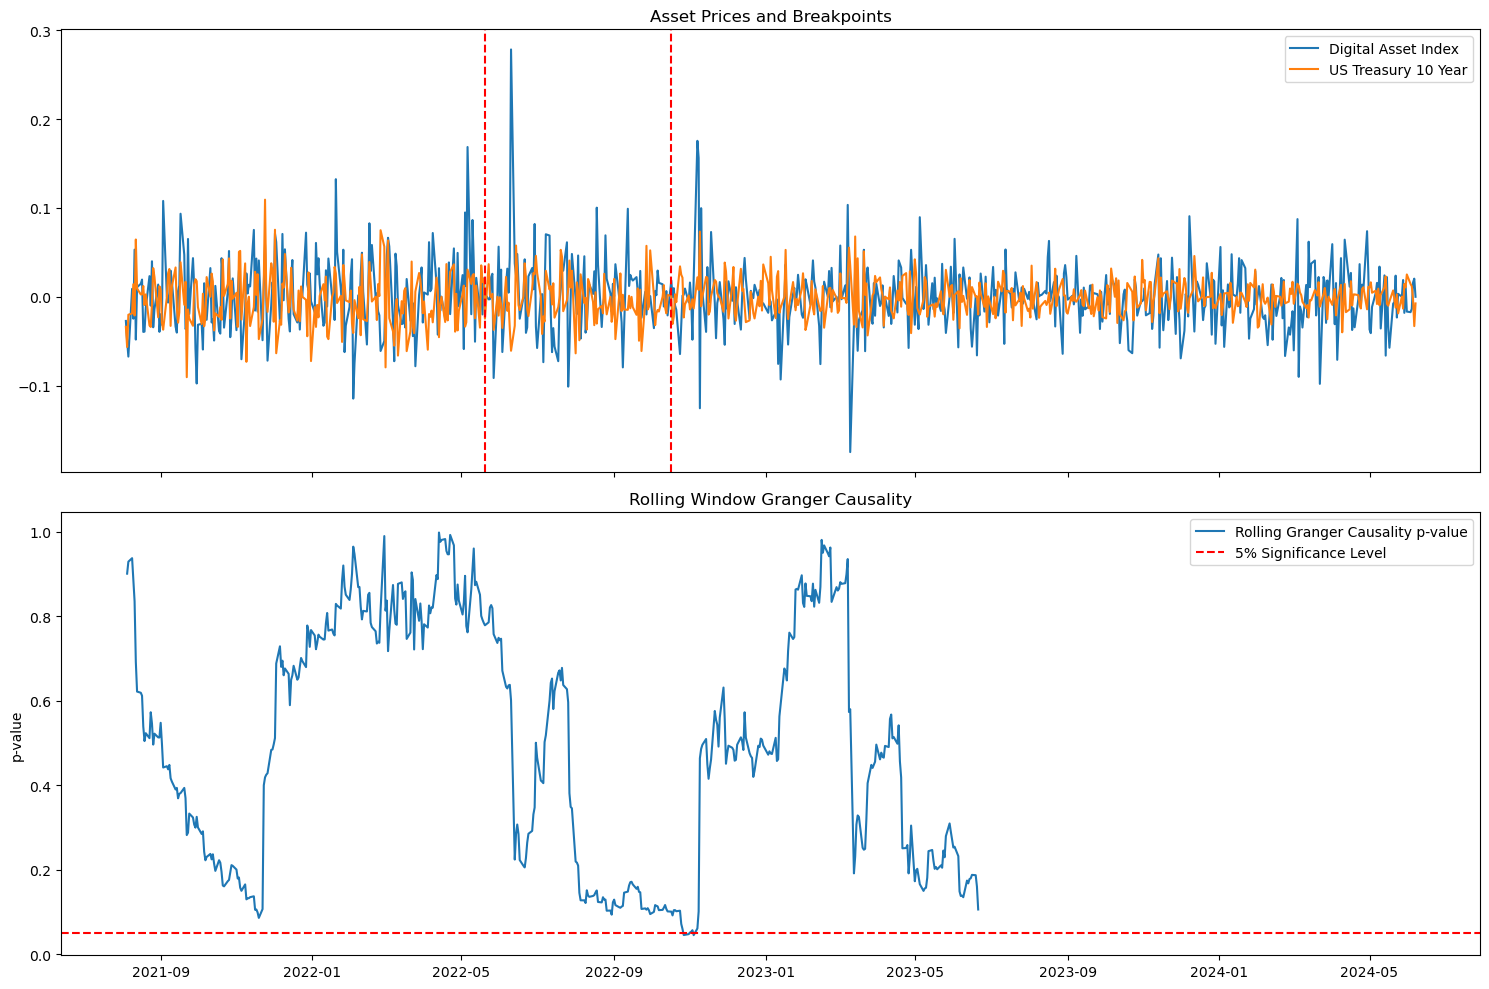

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import het_breuschpagan
from arch import arch_model

# structure breakpoints detection

def breakpoint_test(data):
    rolling_corr = data['S&P_digital_asset_index'].rolling(window=15).corr(data['US_Treasury_10_year'])
    potential_breakpoints = rolling_corr[abs(rolling_corr.diff()) > rolling_corr.std() * 2].index
    
   
    if len(potential_breakpoints) == 0:
        print("No significant breakpoints detected. Using default breakpoints.")
        return [data.index[len(data)//3], data.index[2*len(data)//3]]
    
    return potential_breakpoints

def sub_sample_analysis(data, breakpoints):
    results = {}
    for i in range(len(breakpoints) + 1):
        if i == 0:
            sub_data = data.loc[:breakpoints[i]]
        elif i == len(breakpoints):
            sub_data = data.loc[breakpoints[i-1]:]
        else:
            sub_data = data.loc[breakpoints[i-1]:breakpoints[i]]
        
        if len(sub_data) > 10:  # 确保子样本有足够的数据点
            gc_result = grangercausalitytests(sub_data[['S&P_digital_asset_index', 'US_Treasury_10_year']], maxlag=5, verbose=False)
            results[f'Sub_sample_{i+1}'] = gc_result[1][0]['ssr_ftest'][1]
        else:
            print(f"Warning: Sub-sample {i+1} has insufficient data points for Granger causality test.")
    
    return results

def rolling_granger_causality(data, window_size=252):
    results = []
    for i in range(len(data) - window_size):
        window_data = data.iloc[i:i+window_size]
        gc_result = grangercausalitytests(window_data[['S&P_digital_asset_index', 'US_Treasury_10_year']], maxlag=5, verbose=False)
        results.append({
            'Date': window_data.index[-1],
            'p_value': gc_result[1][0]['ssr_ftest'][1]
        })
    return pd.DataFrame(results).set_index('Date')

def garch_causality(data):
    try:
        garch_model = arch_model(data['S&P_digital_asset_index'], vol='GARCH', p=1, q=1)
        garch_result = garch_model.fit(disp='off')
        
        residuals = garch_result.resid
        combined_data = pd.DataFrame({'residuals': residuals, 'treasury': data['US_Treasury_10_year']})
        gc_result = grangercausalitytests(combined_data, maxlag=5, verbose=False)
        
        return gc_result[1][0]['ssr_ftest'][1]
    except Exception as e:
        print(f"Error in GARCH causality analysis: {e}")
        return None

def advanced_causality_analysis(data):
    print("Data shape:", data.shape)
    print("Data columns:", data.columns)
    print("Data head:\n", data.head())
    
    # breakpoints
    breakpoints = breakpoint_test(data)
    print("Potential breakpoints:", breakpoints)
    
    # sub sample
    sub_sample_results = sub_sample_analysis(data, breakpoints)
    print("Sub-sample Granger Causality results:", sub_sample_results)
    
    # Rolling Granger Causality
    rolling_gc = rolling_granger_causality(data)
    
    # GARCH-based causality
    garch_gc_pvalue = garch_causality(data)
    print("GARCH-based Granger Causality p-value:", garch_gc_pvalue)
    
    #  Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    ax1.plot(data.index, data['S&P_digital_asset_index'], label='Digital Asset Index')
    ax1.plot(data.index, data['US_Treasury_10_year'], label='US Treasury 10 Year')
    for bp in breakpoints:
        ax1.axvline(bp, color='r', linestyle='--')
    ax1.legend()
    ax1.set_title('Asset Prices and Breakpoints')
    
    ax2.plot(rolling_gc.index, rolling_gc['p_value'], label='Rolling Granger Causality p-value')
    ax2.axhline(y=0.05, color='r', linestyle='--', label='5% Significance Level')
    ax2.set_ylabel('p-value')
    ax2.legend()
    ax2.set_title('Rolling Window Granger Causality')
    
    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":
    data = load_and_preprocess_data('/Users/xiaoquanliu/Desktop/data.xlsx')
    advanced_causality_analysis(data)


Data shape: (741, 5)
Data columns: Index(['S&P_digital_asset_index', 'US_Treasury_10_year', 'Global_IG_Bond',
       'Global_HY_Bond', 'Global_Bond_Index'],
      dtype='object')
Data head:
             S&P_digital_asset_index  US_Treasury_10_year  Global_IG_Bond  \
Date                                                                       
2024-06-07                -0.000060            -0.007499        0.001702   
2024-06-06                 0.020376            -0.033044        0.008835   
2024-06-05                 0.015929            -0.002683        0.001123   
2024-06-04                -0.013604             0.011788       -0.003402   
2024-06-03                -0.017356             0.014448        0.000000   

            Global_HY_Bond  Global_Bond_Index  
Date                                           
2024-06-07       -0.000160           0.004513  
2024-06-06        0.002214           0.007382  
2024-06-05        0.001505          -0.000442  
2024-06-04       -0.002878          

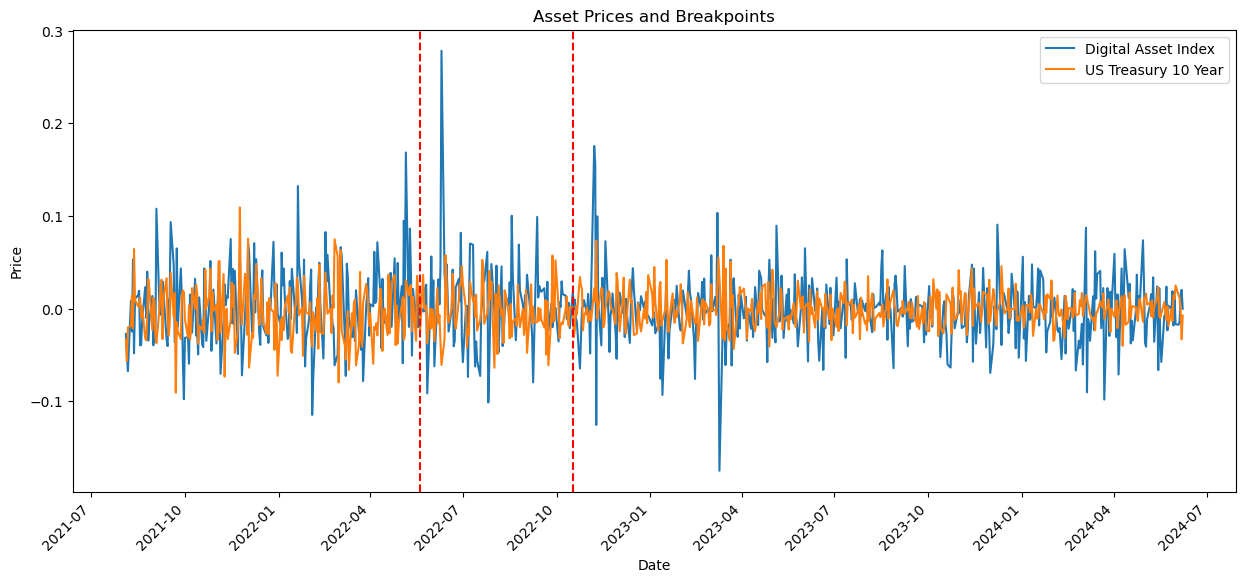

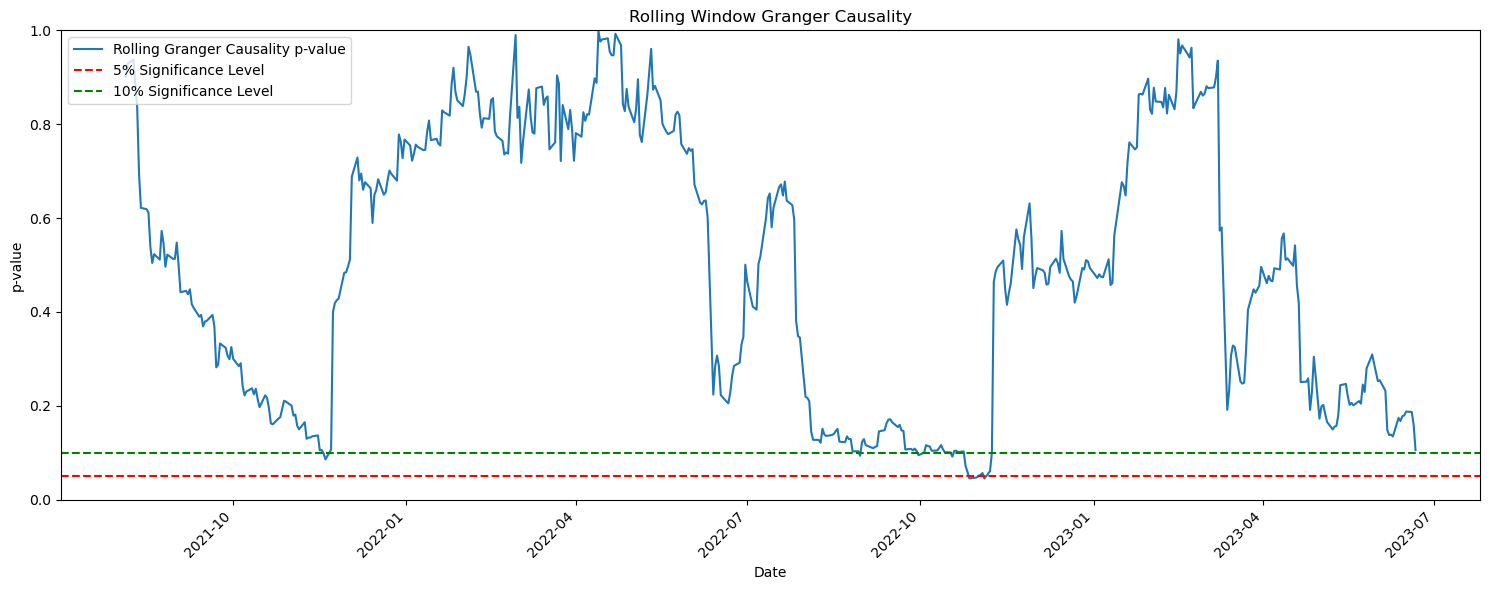

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import het_breuschpagan
from arch import arch_model
import matplotlib.dates as mdates

def advanced_causality_analysis(data):
    print("Data shape:", data.shape)
    print("Data columns:", data.columns)
    print("Data head:\n", data.head())
    
    breakpoints = breakpoint_test(data)
    print("Potential breakpoints:", breakpoints)
    
    sub_sample_results = sub_sample_analysis(data, breakpoints)
    print("Sub-sample Granger Causality results:", sub_sample_results)
    
    rolling_gc = rolling_granger_causality(data)
    
    garch_gc_pvalue = garch_causality(data)
    print("GARCH-based Granger Causality p-value:", garch_gc_pvalue)
    
    # creat two deperate figures
    fig1, ax1 = plt.subplots(figsize=(15, 6))
    fig2, ax2 = plt.subplots(figsize=(15, 6))
    
  
    ax1.plot(data.index, data['S&P_digital_asset_index'], label='Digital Asset Index')
    ax1.plot(data.index, data['US_Treasury_10_year'], label='US Treasury 10 Year')
    for bp in breakpoints:
        ax1.axvline(bp, color='r', linestyle='--')
    ax1.legend()
    ax1.set_title('Asset Prices and Breakpoints')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    
  
    ax2.plot(rolling_gc.index, rolling_gc['p_value'], label='Rolling Granger Causality p-value')
    ax2.axhline(y=0.05, color='r', linestyle='--', label='5% Significance Level')
    ax2.axhline(y=0.1, color='g', linestyle='--', label='10% Significance Level')
    ax2.set_ylabel('p-value')
    ax2.legend()
    ax2.set_title('Rolling Window Granger Causality')
    ax2.set_xlabel('Date')
    
    ax2.set_ylim(0, min(1, ax2.get_ylim()[1]))
    

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# main
if __name__ == "__main__":
    data = load_and_preprocess_data('/Users/xiaoquanliu/Desktop/data.xlsx')
    advanced_causality_analysis(data)